# Density Estimation with KDM

A density estimation model with [Kernel Density Matrices](https://github.com/fagonzalezo/kdm).

In [ ]:
# Uncomment to install the required packages
# !pip install git+https://github.com/fagonzalezo/kdm.git

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import ModelCheckpoint

import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import kdm
from kdm.models import KDMDenEstModel

import tensorflow as tf
import tensorflow_probability as tfp

## ARC dataset

Weird Gaussians from 'Masked Autoregressive Flow for Density Estimation'
***

See the article [here](https://arxiv.org/pdf/1705.07057.pdf) where the distribution of the data is given by the following density:

$$
p(x,y) = \mathcal{N}\left(x_2| 0,4\right) \mathcal{N}\left(x_1|\frac{1}{4}x_2^2,1\right)
$$

### Dataset Generation

In [2]:
dataset_size = 40_000

x2_dist = tfp.distributions.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(dataset_size)
x1 = tfp.distributions.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(dataset_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)
X_densities = x2_dist.prob(x_samples[:,1]) * x1.prob(x_samples[:,0])

Scatter plot of the data

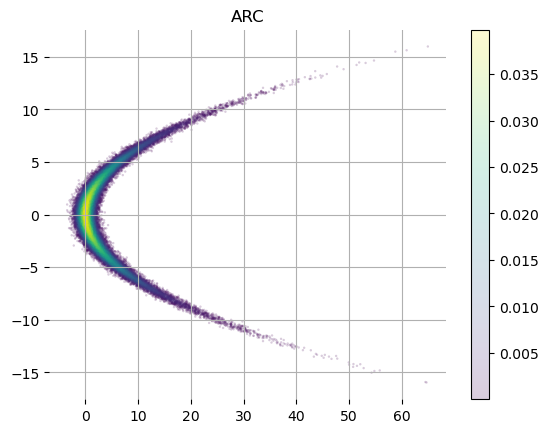

In [3]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x_samples[:,0],  x_samples[:,1], c = X_densities.numpy() , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
#plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

We generate mesh grid data that will be used to calculate probability density plot

In [4]:
x, y = np.mgrid[-10:40:.1, -15:15:.1]
pos = np.dstack((x, y))
X_plot = pos.reshape([150000,2])

real_prob = x2_dist.prob(X_plot[:,1]) * scipy.stats.norm(0.25 * np.square(X_plot[:,1]), 1).pdf(X_plot[:,0])

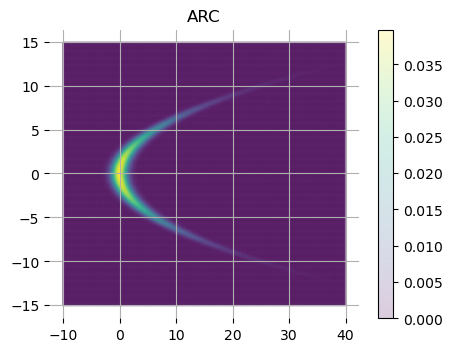

In [5]:
plt.rcParams["figure.figsize"] = (20*0.25,15*0.25)
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x, y, c = real_prob.numpy().reshape([500,300]) , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
#plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

In [6]:
x_train, x_test = train_test_split(x_samples.numpy(), test_size=0.2)

# Train KDM

Now, we train the KDM model with the data. 

In [7]:
def train_de(train_dataset,
             sigma=0.1,
             n_comp=20,
             batch_size=256,
             learning_rate=1e-3,
             epochs=10):
    dim_x = train_dataset.shape[-1]

    # Create the KDM density model
    kdmdensity = KDMDenEstModel(
                                dim_x=dim_x,
                                sigma=sigma,
                                n_comp=n_comp)
    
    # Initialize train density matrix component
    idx = np.random.randint(train_dataset.shape[0], size=n_comp)
    kdmdensity.init_components(train_dataset[idx], init_sigma=True, sigma_mult=0.05)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    kdmdensity.compile(optimizer=optimizer)
    
    # Plot the initial position of the KDM components
    centroids = kdmdensity.kdmproj.c_x.numpy()
    plt.scatter(centroids[:, 0], centroids[:, 1])
    plt.show()

    # Train the KDM density model
    sigmas = []
    losses = []
    for i in range(epochs):
        history = kdmdensity.fit(train_dataset,
                        epochs=1, batch_size=batch_size, verbose=0)
        sigmas.append(kdmdensity.kdmproj.kernel.sigma.numpy())
        losses.append(history.history['loss'][0])

    # Plot the final position of the KDM components
    centroids = kdmdensity.kdmproj.c_x.numpy()
    plt.scatter(centroids[:, 0], centroids[:, 1])
    plt.show()
    
    return kdmdensity, sigmas , losses

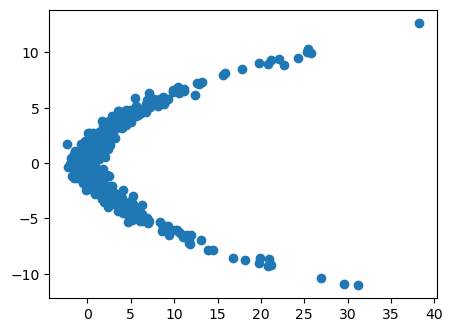

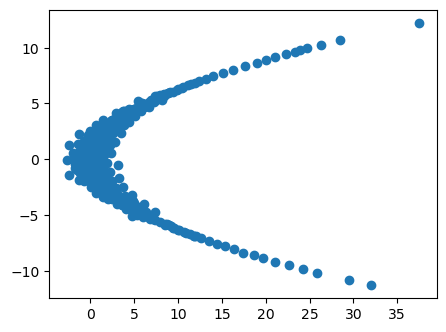

In [8]:
de_kdm, sigmas, losses = train_de(x_train, n_comp=400, epochs=100)

The training process reorganizes the KDM components to better represent the data distribution. Simultaneously, the model learns the optimal sigma for each component.

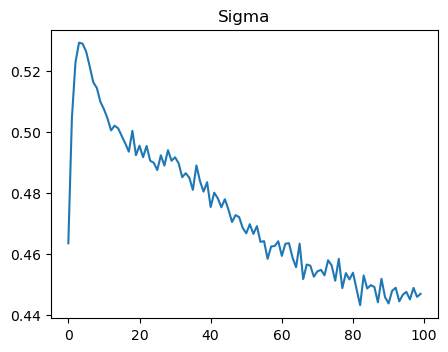

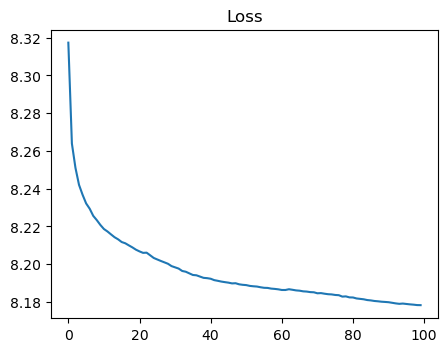

In [9]:
# Plot the evolution of the sigma and the loss
plt.title('Sigma')
plt.plot(sigmas)
plt.show()
plt.title('Loss')
plt.plot(losses)
plt.show()

From the the resulting KDM model, we can obtain the probability distribution of the data.

In [12]:
distrib = de_kdm.get_distrib()

We use the obtained probability distribution to calculate the probability density plot.

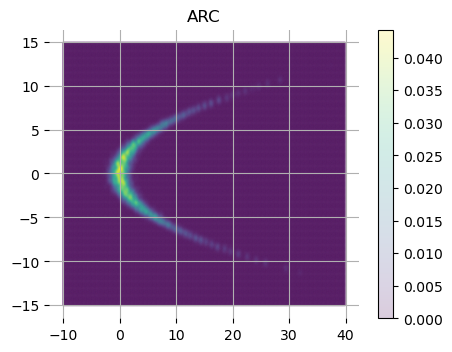

In [13]:
pred_prob = np.exp(distrib.log_prob(X_plot))
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x, y, c = pred_prob.reshape([500,300]) , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')

#plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()